In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Part A: Data Exploration and Baseline Model 

## 1. Load and Analyze the Dataset

In [2]:
df = pd.read_csv("creditcard.csv")   # ensure file is in working dir
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Quick peek
display(df.head())

Dataset shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Analyze Class Distribution

In [3]:
class_counts = df['Class'].value_counts().sort_index()
total = class_counts.sum()
fraud_count = class_counts.loc[1]
nonfraud_count = class_counts.loc[0]
fraud_pct = fraud_count / total * 100
nonfraud_pct = nonfraud_count / total * 100

print(f"Non-fraudulent (Class=0): {nonfraud_count} ({nonfraud_pct:.4f}%)")
print(f"Fraudulent     (Class=1): {fraud_count} ({fraud_pct:.4f}%)")
print(f"Imbalance ratio (non-fraud : fraud) = {nonfraud_count} : {fraud_count}  (approx {nonfraud_count/fraud_count:.0f}:1)")


Non-fraudulent (Class=0): 284315 (99.8273%)
Fraudulent     (Class=1): 492 (0.1727%)
Imbalance ratio (non-fraud : fraud) = 284315 : 492  (approx 578:1)


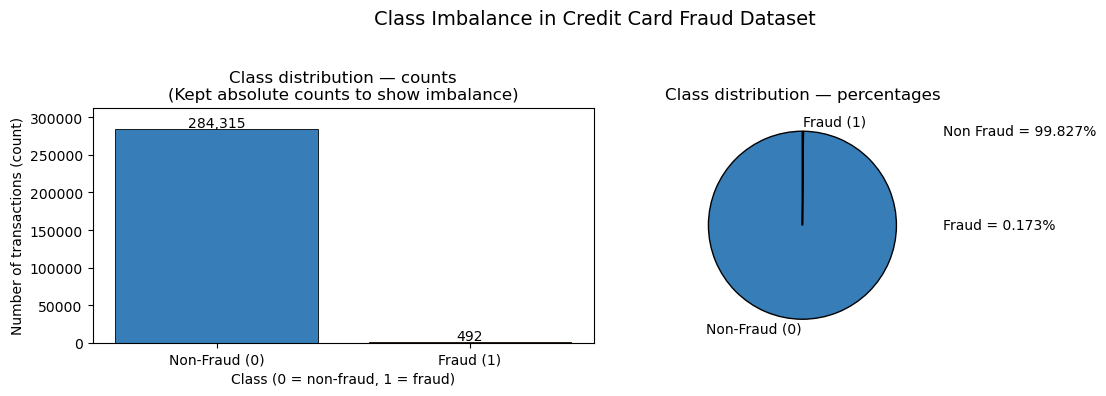



Plot description: The dataset is extremely imbalanced — fraud is a tiny fraction of all transactions.
 Seven commandments applied: colorblind-safe palette, labeled axes, scale noted, legend/pct in pie, title + description.


In [64]:

palette = ['#377eb8', '#ff7f00']  
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Bar
axes[0].bar(['Non-Fraud (0)', 'Fraud (1)'], [nonfraud_count, fraud_count], color=palette, edgecolor='k', linewidth=0.6)
axes[0].set_title("Class distribution — counts\n(Kept absolute counts to show imbalance)", fontsize=12)
axes[0].set_xlabel("Class (0 = non-fraud, 1 = fraud)")
axes[0].set_ylabel("Number of transactions (count)")
axes[0].set_yscale('linear')  
ymax = max(nonfraud_count, fraud_count) * 1.1   # add 5% padding
axes[0].set_ylim(0, ymax)
axes[0].annotate(f"{nonfraud_count:,}", xy=(0, nonfraud_count), xytext=(0, nonfraud_count*1.01), ha='center')
axes[0].annotate(f"{fraud_count:,}", xy=(1, fraud_count), xytext=(1, fraud_count*7), ha='center')

# Pie
# axes[1].pie(
#     [nonfraud_count, fraud_count],
#     labels=['Non-Fraud (0)', 'Fraud (1)'],
#     autopct=lambda pct: f"{pct:.3f}%",
#     colors=palette,
#     startangle=90,
#     wedgeprops={'edgecolor':'k'},
#     pctdistance=0.8
# )
axes[1].set_title("Class distribution — percentages", fontsize=12)

axes[1].pie(
    [nonfraud_count, fraud_count],
    labels=['Non-Fraud (0)', 'Fraud (1)'],
    colors=palette,
    startangle=90,
    wedgeprops={'edgecolor':'k'}
)

axes[1].text(1.5, 0, f"Fraud = {fraud_pct:.3f}%", ha='left', va='center', fontsize=10)
axes[1].text(1.5, 1, f"Non Fraud = {nonfraud_pct:.3f}%", ha='left', va='center', fontsize=10)


fig.suptitle("Class Imbalance in Credit Card Fraud Dataset", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])

plt.show()
print( "\n\nPlot description: The dataset is extremely imbalanced — fraud is a tiny fraction of all transactions.\n Seven commandments applied: colorblind-safe palette, labeled axes, scale noted, legend/pct in pie, title + description.")


## 3. Baseline Model

In [8]:
# Features and labels
X = df.drop(columns=['Class'])
y = df['Class']

# Note: dataset already uses PCA (V1..V28). It's good to scale Amount (and maybe Time) for logistic regression.
# We'll scale Amount and Time; the PCA features are already centered by the original preprocessing.
scaler = StandardScaler()
X_scaled = X.copy()
if 'Amount' in X.columns:
    X_scaled['Amount'] = scaler.fit_transform(X[['Amount']])
if 'Time' in X.columns:
    # Optionally scale Time too
    X_scaled['Time'] = scaler.fit_transform(X[['Time']])

# Split ensuring the test set preserves original imbalance.
# Use stratify=y so both train and test keep the same class proportion as the full dataset.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))



Train shape: (213605, 30) Test shape: (71202, 30)
Train class distribution:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
Test class distribution:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64



Classification Report:
                precision    recall  f1-score   support

Non-Fraud (0)     0.9994    0.9998    0.9996     71079
    Fraud (1)     0.8462    0.6260    0.7196       123

     accuracy                         0.9992     71202
    macro avg     0.9228    0.8129    0.8596     71202
 weighted avg     0.9991    0.9992    0.9991     71202

Fraud (class=1) — Precision: 0.8462, Recall: 0.6260, F1-score: 0.7196

Overall accuracy: 0.9992

NOTE: With a highly imbalanced dataset, a classifier that always predicts 'non-fraud' would still achieve very high accuracy.
Always prefer precision, recall, F1 (especially recall for catching fraud) and confusion matrix for class-imbalanced tasks.


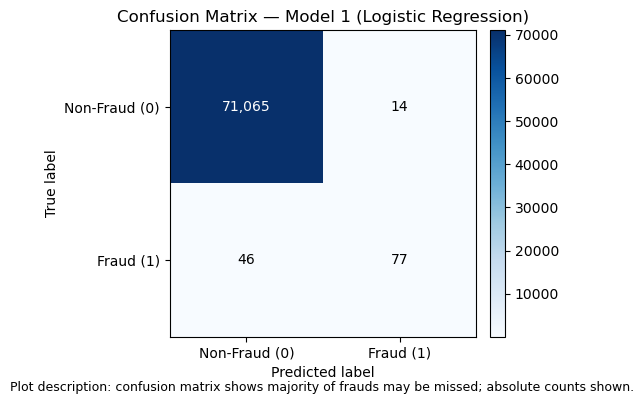

In [67]:

# Baseline logistic regression model on imbalanced training data (Model 1)
# IMPORTANT: Baseline uses default (no class weighting) to illustrate baseline performance under imbalance.
model1 = LogisticRegression(max_iter=1000, solver='liblinear')  # solver ok for small datasets
model1.fit(X_train, y_train)

# Predictions & evaluation
y_pred = model1.predict(X_test)
y_proba = model1.predict_proba(X_test)[:,1]


report = classification_report(y_test, y_pred, digits=4, target_names=['Non-Fraud (0)', 'Fraud (1)'])
print("\nClassification Report:\n", report)

# Compute precision/recall/f1 specifically for the fraud class
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[1], average='binary')
print(f"Fraud (class=1) — Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# Accuracy (for demonstration why it's misleading)
accuracy = (y_pred == y_test).mean()
print(f"\nOverall accuracy: {accuracy:.4f}")
print("\nNOTE: With a highly imbalanced dataset, a classifier that always predicts 'non-fraud' would still achieve very high accuracy.")
print("Always prefer precision, recall, F1 (especially recall for catching fraud) and confusion matrix for class-imbalanced tasks.")

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix — Model 1 (Logistic Regression)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0,1]); ax.set_xticklabels(['Non-Fraud (0)','Fraud (1)'])
ax.set_yticks([0,1]); ax.set_yticklabels(['Non-Fraud (0)','Fraud (1)'])
# annotate
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i,j]:,}", ha="center", va="center",
                color="white" if cm[i,j] > thresh else "black")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.figtext(0.5, 0.01,
            "Plot description: confusion matrix shows majority of frauds may be missed; absolute counts shown.",
            ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Part B: Resampling Approaches

## 1 Naive Oversampling


Before SMOTE: training class distribution
Class
0    213236
1       369
Name: count, dtype: int64

After SMOTE: training class distribution
Class
0    213236
1    213236
Name: count, dtype: int64

Classification Report (SMOTE Model):
               precision    recall  f1-score   support

Non-Fraud (0)     0.9998    0.9758    0.9877     71079
    Fraud (1)     0.0597    0.8862    0.1118       123

     accuracy                         0.9757     71202
    macro avg     0.5297    0.9310    0.5497     71202
 weighted avg     0.9982    0.9757    0.9862     71202

Fraud (class=1) — Precision: 0.0597, Recall: 0.8862, F1-score: 0.1118


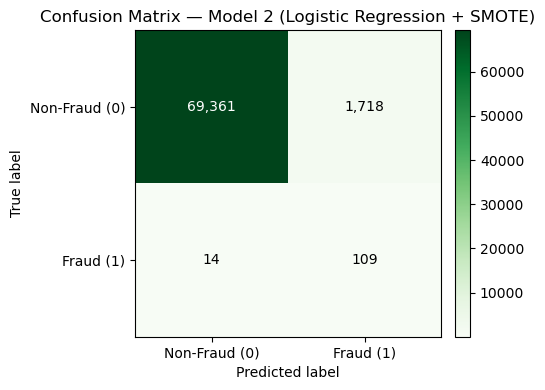

Plot description: Confusion matrix after SMOTE shows improved recall (more fraud cases detected). But precision may drop due to more false positives.


In [76]:

# 1. Apply SMOTE on training data
print("\nBefore SMOTE: training class distribution")
print(y_train.value_counts())

smote = SMOTE(random_state=42, sampling_strategy=1.0)  # balance minority = majority
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE: training class distribution")
print(y_train_smote.value_counts())

# Train logistic regression on SMOTE data (Model 2)
model2 = LogisticRegression(max_iter=1000, solver='liblinear')
model2.fit(X_train_smote, y_train_smote)

# Evaluate on original imbalanced test set
y_pred_smote = model2.predict(X_test)

# print("\nConfusion Matrix (SMOTE Model):")
# print(confusion_matrix(y_test, y_pred_smote))

print("\nClassification Report (SMOTE Model):")
print(classification_report(y_test, y_pred_smote, digits=4, target_names=['Non-Fraud (0)', 'Fraud (1)']))

prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_smote, labels=[1], average='binary')
print(f"Fraud (class=1) — Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")


cm_smote = confusion_matrix(y_test, y_pred_smote)


fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm_smote, interpolation='nearest', cmap=plt.cm.Greens)
ax.set_title("Confusion Matrix — Model 2 (Logistic Regression + SMOTE)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0,1]); ax.set_xticklabels(['Non-Fraud (0)','Fraud (1)'])
ax.set_yticks([0,1]); ax.set_yticklabels(['Non-Fraud (0)','Fraud (1)'])
# Annotate each cell with count
thresh = cm_smote.max() / 2.
for i in range(cm_smote.shape[0]):
    for j in range(cm_smote.shape[1]):
        ax.text(j, i, f"{cm_smote[i,j]:,}", ha="center", va="center",
                color="white" if cm_smote[i,j] > thresh else "black")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("Plot description: Confusion matrix after SMOTE shows improved recall (more fraud cases detected). But precision may drop due to more false positives.")


##  Resampling Approaches — SMOTE

###  What is SMOTE?
SMOTE (**Synthetic Minority Over-sampling Technique**) is an advanced oversampling method designed to handle class imbalance problems.  
Instead of simply duplicating minority class samples (frauds), SMOTE generates **synthetic samples** by interpolating between existing minority examples and their nearest neighbors.  

**How it works:**
1. For each minority-class instance, SMOTE finds its *k nearest neighbors* (typically `k=5`).
2. One neighbor is randomly chosen.
3. A new synthetic sample is created along the line segment between the instance and the neighbor:  
   $
   x_{new} = x_i + \delta \times (x_{neighbor} - x_i), \quad \delta \in [0,1]
   $
4. This process is repeated until the minority class is balanced with the majority class.

By creating synthetic points **inside the feature space**, SMOTE helps the classifier generalize better than naive oversampling.

---

###  Why use SMOTE here?
- Our dataset is **extremely imbalanced** (fraud ≈ 0.17% of transactions).
- Logistic Regression trained on this imbalance tends to **ignore the fraud class**.
- SMOTE balances the training set, enabling the model to **learn patterns of fraud more effectively**.

---

###  Limitations of SMOTE
While powerful, SMOTE has some potential drawbacks:
- **Noisy synthetic samples**: If frauds are scattered or overlap with non-frauds, SMOTE may generate unrealistic points.
- **Boundary issues**: Synthetic frauds near the class boundary might confuse the classifier.
- **High dimensionality**: With many features (like 28 PCA components), nearest-neighbor calculations may be less reliable.
- **Computational cost**: Balancing classes increases dataset size, so training becomes heavier.
- **Does not fix test imbalance**: The test set remains imbalanced (as it should), so evaluation metrics must still focus on Precision, Recall, and F1 rather than Accuracy.

---

###  Expected Impact
- **Recall (Sensitivity)** for fraud improves significantly → the model catches more fraudulent cases.
- **Precision** may drop slightly → more false positives are introduced.
- **F1-score** (balance between precision & recall) usually improves, showing a better trade-off.

---

